In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import threading
from netCDF4 import Dataset
import os

In [5]:
def vapor_pressure(T,method = 'ARM'):
    """
    Returns vapor pressure in Pa from temperature in Celsius

    Parameters
    ----------
    T : float
        Temperature in C
    """
    if method in ['ARM']:
        P = 0.61094*np.exp(17.625*T/(T+243.04)) # kPa
    elif method in ['Sonntag']:
        # follows COSIPY
        T += 273.15
        if T > 273.15:  # over water
            P = 0.6112*np.exp(17.67*(T-273.15)/(T-29.66))
        else: # over ice
            P = 0.6112*np.exp(22.46*(T-273.15)/(T-0.55))
    return P*1000

In [6]:
def stable_PhiM(z,L):
    zeta = z/L
    if zeta > 1.:
        phim = -4*(1+np.log(zeta)) - zeta
    elif zeta > 0.:
        phim = -5*zeta
    else:
        phim = 0
    return phim

def PhiM(z,L):
    if L < 0:
        X = np.power((1-16*z/L),0.25)
        phim = 2*np.log((1+X)/2) + np.log((1+X**2)/2) - 2*np.arctan(X) + np.pi/2
    elif L > 0: # stable
        phim = stable_PhiM(z, L)
    else:
        phim = 0.0
    return phim

def PhiT(z,L):
    if L < 0:
        X = np.power((1-19.3*z/L),0.25)
        phit = 2*np.log((1+X**2)/2)
    elif L > 0: # stable
        phit = stable_PhiM(z, L)
    else:
        phit = 0.0
    return phit



In [11]:
# CONSTANTS
KARMAN = 0.4
GRAVITY = 9.81
R_GAS = 8.3144598
MM_AIR = 0.0289644
CP_AIR = 1005

# ROUGHNESS LENGTHS
roughness = 1.7
z0 = roughness  # Roughness length for momentum
z0t = z0/100    # Roughness length for heat
z0q = z0/10     # Roughness length for moisture

# SLOPE
slope = 10
cos_slope = np.cos(np.radians(slope))

# ADJUST WIND SPEED
z = 2 # reference height in m
wind = 1.5
rH = 60
tempC = 2
tempK = tempC + 273.15
surftemp = 0
sp = 100325

# Transform humidity into mixing ratio (q), get air density from PV=nRT
Ewz = vapor_pressure(tempC)  # vapor pressure at 2m
Ew0 = vapor_pressure(surftemp) # vapor pressure at the surface
qz = (rH/100)*0.622*(Ewz/(sp-Ewz))
q0 = 1.0*0.622*(Ew0/(sp-Ew0))
density_air = sp/R_GAS/tempK*MM_AIR

# Initiate loop with neutral stratification
loop = True
PsiT0 = 0
PsiM0 = 0
previous_zeta = 0

# Latent heat term depends on direction of heat exchange
if surftemp == 0. and (qz-q0) > 0:
    Lv = 2.514e6
else:
    Lv = 2.849e6 

counter = 0
L = 0
Qs_last = np.inf
while loop:
    # calculate stability terms
    fric_vel = KARMAN*wind / (np.log(z/z0)-PhiM(z,L))
    cD = KARMAN**2/np.square(np.log(z/z0) - PhiM(z,L) - PhiM(z0,L))
    csT = KARMAN*np.sqrt(cD) / (np.log(z/z0t) - PhiT(z,L) - PhiT(z0,L))
    csQ = KARMAN*np.sqrt(cD) / (np.log(z/z0q) - PhiT(z,L) - PhiT(z0,L))

    # calculate fluxes
    Qs = density_air*CP_AIR*csT*wind*(tempC - surftemp)
    Ql = density_air*Lv*csQ*wind*(qz-q0)

    # recalculate L
    L = fric_vel**3*(tempK)*density_air*CP_AIR/(KARMAN*GRAVITY*Qs)

    # check convergence
    counter += 1
    diff = np.abs(Qs_last-Qs)
    if counter > 10 or diff < 1e-1:
        loop = False
        if counter > 10:
            print('didnt converge')
    Qs_last = Qs
print(Qs,Ql)

774.5872927372079 -2478.802259103884


In [29]:
# CONVERT ERA5 DEWPOINT TEMPERATURE TO RELATIVE HUMIDITY
import xarray as xr
import numpy as np
era5_dt = xr.open_dataset('~/research/climate_data/ERA5/ERA5_hourly/ERA5_dtemp_hourly.nc')
era5_t = xr.open_dataset('~/research/climate_data/ERA5/ERA5_hourly/ERA5_temp_hourly.nc')
def vapor_pressure(T,units='K'):
    if units=='K':
        T -= 273.15
    P = 0.61094*np.exp(17.625*T/(T+243.04)) # kPa
    return P*1000
era5_vp = vapor_pressure(era5_dt.d2m.values) / vapor_pressure(era5_t.t2m.values)
era5_out = era5_dt.copy()
era5_out['rh'] = (['time','latitude','longitude'],era5_vp)
era5_out = era5_out.drop_vars('d2m')
era5_out = era5_out.assign_attrs({'units':'0-1','long_name':'2 metre relative humidity'})
print(era5_out)
# era5_out.plot.scatter('time','rh')
era5_out.to_netcdf('~/research/climate_data/ERA5/ERA5_hourly/ERA5_rh_hourly.nc')

<xarray.Dataset>
Dimensions:    (longitude: 1, latitude: 1, time: 368184)
Coordinates:
  * longitude  (longitude) float32 -145.5
  * latitude   (latitude) float32 63.34
  * time       (time) datetime64[ns] 1980-01-01 ... 2021-12-31T23:00:00
Data variables:
    rh         (time, latitude, longitude) float32 0.9798 0.9804 ... 0.9888
Attributes:
    units:      0-1
    long_name:  2 metre relative humidity


In [4]:
# CONVERT MERRA2 SPECIFIC HUMIDITY TO RELATIVE HUMIDITY
import xarray as xr
import numpy as np
import pandas as pd
LAT = '60'
LON = '-150'
time = pd.date_range('04-03-2023 00:30','08-25-2023 23:30',freq='h')
merra2_qv = xr.open_dataset(f'~/research/climate_data/MERRA2/QV2M/MERRA2_QV2M_{LAT}_{LON}.nc')
# print(merra2_qv.coords['time']) #.sel(time=time)
merra2_sp = xr.open_dataset(f'~/research/climate_data/MERRA2/PS/MERRA2_PS_{LAT}_{LON}.nc')
merra2_t = xr.open_dataset(f'~/research/climate_data/MERRA2/T2M/MERRA2_T2M_{LAT}_{LON}.nc')
def vapor_pressure(T,units='K'):
    if units=='K':
        T -= 273.15
    P = 0.61094*np.exp(17.625*T/(T+243.04)) # kPa
    return P*1000
esat = vapor_pressure(merra2_t.T2M.values)
ws = 0.622*esat / merra2_sp.PS.values
w = merra2_qv.QV2M.values
rh = w / ws
merra2_out = merra2_qv.copy()
merra2_out['RH2M'] = (['time','lat','lon'],rh,{'units':'1','long_name':'2-meter_relative_humidity'})
merra2_out = merra2_out.drop_vars('QV2M')
merra2_out.to_netcdf(f'~/research/climate_data/MERRA2/RH2M/MERRA2_RH2M_{LAT}_{LON}.nc')

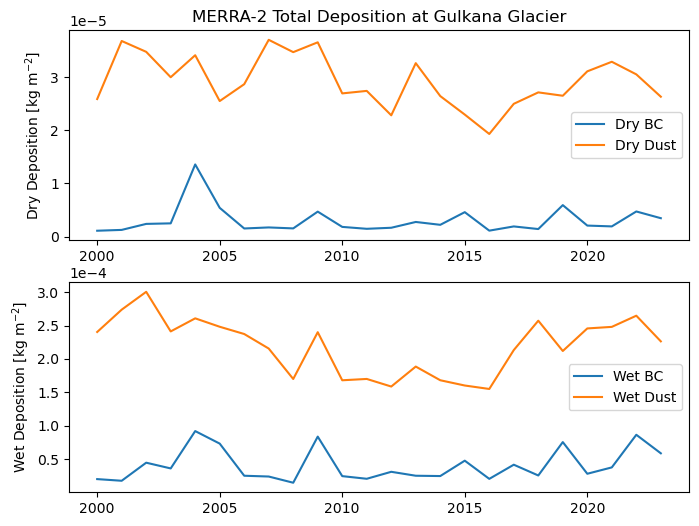

In [38]:
# LOOK AT ANNUAL DEPOSITION
fp = '~/research/climate_data/MERRA2/'
lat = '60'
lon = '-150'
bcdry = xr.open_dataset(fp+f'BCDP002/MERRA2_BCDP002_{lat}_{lon}.nc').sel(lat=63.5,lon=-145.625)
bcwet = xr.open_dataset(fp+f'BCWT002/MERRA2_BCWT002_{lat}_{lon}.nc').sel(lat=63.5,lon=-145.625)
dudry = xr.open_dataset(fp+f'DUDP003/MERRA2_DUDP003_{lat}_{lon}.nc').sel(lat=63.5,lon=-145.625)
duwet = xr.open_dataset(fp+f'DUWT003/MERRA2_DUWT003_{lat}_{lon}.nc').sel(lat=63.5,lon=-145.625)
bcdry = bcdry * 3600 * 2.08 # apply multiplicative factor to get total BC from species 2
bcwet = bcwet * 3600 * 2.08 # also convert from rate to total
dudry = dudry * 3600 * 3
duwet = duwet * 3600 * 3

dep_dict = {'bcdry':{'ds':bcdry,'annual':[],'name':'BCDP002'},
            'bcwet':{'ds':bcwet,'annual':[],'name':'BCWT002'},
            'dudry':{'ds':dudry,'annual':[],'name':'DUDP003'},
            'duwet':{'ds':duwet,'annual':[],'name':'DUWT003'}}
years = np.arange(2000,2024)
for var in list(dep_dict.keys()):
    for year in years:
        jan1 = str(year)+'-01-01 00:30'
        dec31 = str(year)+'-12-31 23:30'
        dates = pd.date_range(jan1,dec31,freq='h')
        annual_dep = np.sum(dep_dict[var]['ds'].sel(time=dates)[dep_dict[var]['name']].values)
        dep_dict[var]['annual'].append(annual_dep)

fig,[ax1,ax2] = plt.subplots(2,figsize=(8,6))
ax2.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
ax1.plot(years,dep_dict['bcdry']['annual'],label='Dry BC')
ax2.plot(years,dep_dict['bcwet']['annual'],label='Wet BC')
ax1.plot(years,dep_dict['dudry']['annual'],label='Dry Dust')
ax2.plot(years,dep_dict['duwet']['annual'],label='Wet Dust')
ax1.set_ylabel('Dry Deposition [kg m$^{-2}$]')
ax2.set_ylabel('Wet Deposition [kg m$^{-2}$]')
ax1.legend()
ax2.legend()
ax1.set_title('MERRA-2 Total Deposition at Gulkana Glacier')
plt.show()

In [21]:
# FAST IMPORT FOR TIMING
%load_ext autoreload
%autoreload 2
import pygem_eb.input as eb_prms
import pandas as pd
eb_prms.enddate = eb_prms.startdate + pd.Timedelta(hours=2)
import run_simulation_eb as sim
eb_prms.enddate = pd.to_datetime('2023-08-09 00:30')
import pygem_eb.massbalance as mb

Running 1 bin(s) at [1542.0] m a.s.l. for 4.0 months starting in April, 2023
1 glaciers in region 1 are included in this model run: ['00570']
This study is focusing on 1 glaciers in region [1]
Check variable units:  RH2M 1
Check variable units:  PS Pa
Check variable units:  CLDTOT 1
Check variable units:  SWGDN W m-2
Check variable units:  LWGAB W m-2
Check variable units:  U2M m s-1
Check variable units:  V2M m s-1
Check variable units:  BCDP002 kg m-2 s-1
Check variable units:  BCWT002 kg m-2 s-1
Check variable units:  DUDP003 kg m-2 s-1
Check variable units:  DUWT003 kg m-2 s-1
19 layers initialized for bin 0
MONTH COMPLETED: April 2023 with +0.02 and -0.00 m w.e.
Currently -6.76 C with 1 W m-2 melt energy
----------surface albedo: 0.840 -----------
-----------surface temp: -9.81 C-----------
|       snow depth: 2.34 m      10 layers      |
|       ice depth: 200.00 m      11 layers      |
--------------------layer 0---------------------
     T = -6.7 C                 h = 0.034 m 


In [23]:
args = sim.get_args()
climateds_merra,dates_table,utils = sim.initialize_model('01.00570',args)
massbal = mb.massBalance(0,dates_table,args,utils)
%load_ext line_profiler
%lprun -f massbal.main massbal.main(climateds_merra)

Running 1 bin(s) at [1542.0] m a.s.l. for 4.0 months starting in April, 2023


2015 0.00012285003


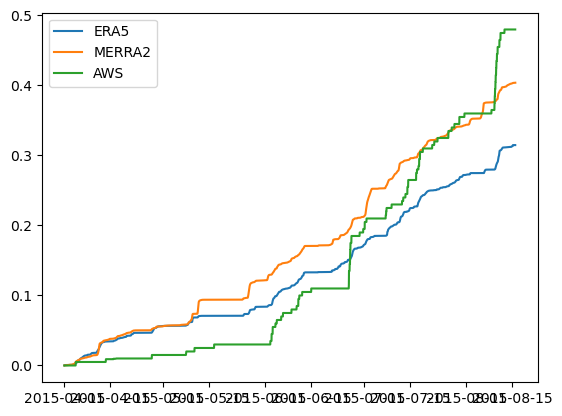

2016 0.00015638002


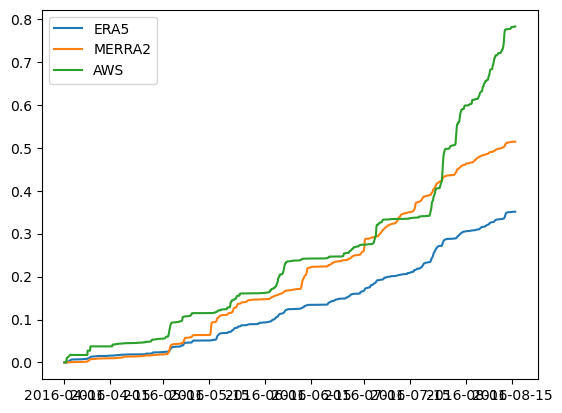

2017 0.00014598707


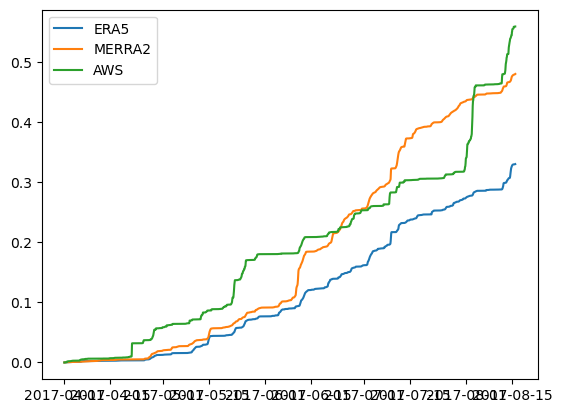

2018 0.00017880037


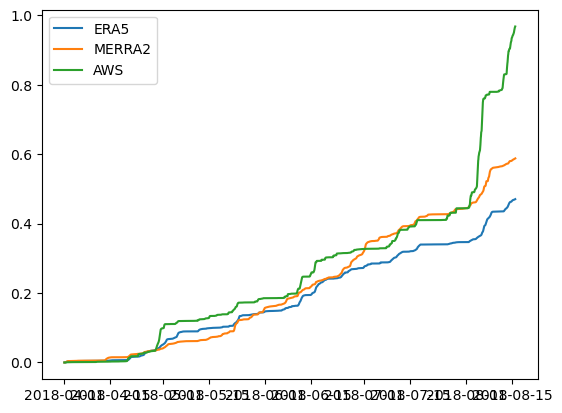

2019 0.00013557216


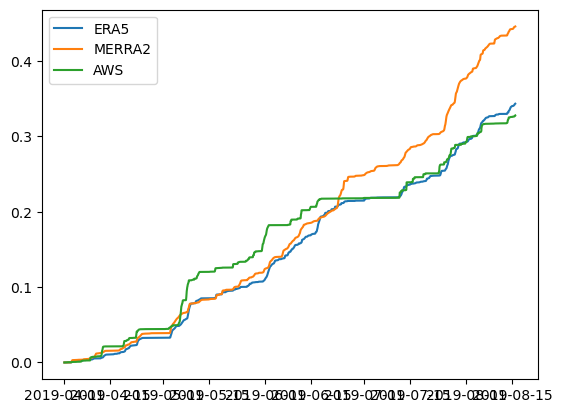

In [11]:
# PLOT MERRA2 vs ERA5
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# OPEN MERRA2 DATASET AND SELECT TIME / LAT / LON
df = pd.read_csv('~/research/climate_data/AWS/Gulkana/LVL2/gulkana1725_hourly_LVL2_new.csv')
df = df.rename(columns={'TPGIncremental':'tp','site_temp_USGS':'temp'})
df['tp'] = df['tp'].astype(float) / 1000
df = df.set_index(pd.to_datetime(df['local_time']))

for year in np.arange(2015,2020):
    year = str(year)
    time_m = pd.date_range(year+'-04-01 00:30',year+'-08-15 23:30',freq='h')
    ds_merra2 = xr.open_dataset('~/research/climate_data/MERRA2/PRECTOTCORR/MERRA2_PRECTOTCORR_60_-150.nc')
    tp_m = ds_merra2.sel(lat=63.5,lon=-145.625,time=time_m)
    # OPEN ERA5 DATASET AND SELECT TIME / LAT / LON
    time_e = time_m - pd.Timedelta(minutes=30)
    ds_era5 = xr.open_dataset('~/research/climate_data/ERA5/ERA5_hourly/ERA5_precip_hourly.nc')
    tp_e = ds_era5.sel(time=time_e) # latitude=63.3,longitude=-145.5,
    tp_e = tp_e['tp'].to_numpy().flatten()
    tp_m = tp_m['PRECTOTCORR'].to_numpy()*3600/1000
    df_plot = df.loc[time_e]
    print(year,np.mean(tp_m))
    plt.plot(time_e,np.cumsum(tp_e),label='ERA5')
    plt.plot(time_m,np.cumsum(tp_m),label='MERRA2')
    plt.plot(df_plot.index,df_plot['tp'].cumsum(),label='AWS')
    plt.legend()
    plt.show()

In [7]:
# TEST SNICAR
import sys, os, yaml
sys.path.append('/home/claire/research/PyGEM-EB/biosnicar-py/src/')
import biosnicar as snicar
fp = '/home/claire/research/PyGEM-EB/biosnicar-py/src/biosnicar/inputs.yaml'
output_dict = dict()
run = 0

In [19]:
with open(fp) as f:
    list_doc = yaml.safe_load(f)
n_layers = 3
# Update changing layer variables
BC = [1293,5,5] # clean snow 0-3ppb, dirty 2-15ppb
dust = [9000,9000,9000] # in ppm converts to ppb, clean snow 0-2e4 ppb, dirty 1e4-1e5 ppb
rho = [600,600,800]
grainsize = [350,800,1200]

list_doc['IMPURITIES']['BC']['CONC'] = BC
list_doc['IMPURITIES']['DUST1']['CONC'] = [d*0.0834444*1000 for d in dust]
list_doc['IMPURITIES']['DUST2']['CONC'] = [d*0.19784*1000 for d in dust]
list_doc['IMPURITIES']['DUST3']['CONC'] = [d*0.481675*1000 for d in dust]
list_doc['IMPURITIES']['DUST4']['CONC'] = [d*0.203786*1000 for d in dust]
list_doc['IMPURITIES']['DUST5']['CONC'] = [d*0.034*1000 for d in dust]
list_doc['ICE']['DZ'] = [0.05,0.1,10]
list_doc['ICE']['RHO'] = rho
list_doc['ICE']['RDS'] = grainsize

# Following variables are set to constants, but need to have right number of layers
ice_variables = ['LAYER_TYPE','SHP','HEX_SIDE','HEX_LENGTH','SHP_FCTR','WATER','AR','CDOM']
for var in ice_variables:
    list_doc['ICE'][var] = [list_doc['ICE'][var][0]] * n_layers

# Save SNICAR input file
with open(fp, 'w') as f:
    yaml.dump(list_doc,f)

albedo,wv = snicar.main.get_albedo('adding-doubling',plot=False,validate=False)
bba = np.sum(albedo*wv) / np.sum(wv)
print(bba)

output_dict[run] = {'BC':BC,'dust':dust,'grainsize':grainsize,
                    'rho':rho,'albedo':bba}

run += 1


Running biosnicar with the adding-doubling solver

0.6044679595461305


In [20]:
for i in range(len(output_dict)):
    print('BC:',sum(output_dict[i]['BC']),'grain size:',output_dict[i]['grainsize'],'albedo:',output_dict[i]['albedo'])

BC: 0.30000000000000004 grain size: [60, 800, 1200] albedo: 0.869543728853874
BC: 0.30000000000000004 grain size: [60, 800, 1200] albedo: 0.869543728853874
BC: 5.199999999999999 grain size: [60, 800, 1200] albedo: 0.8562356553176238
BC: 5.199999999999999 grain size: [150, 800, 1200] albedo: 0.8159694751614391
BC: 5.199999999999999 grain size: [200, 800, 1200] albedo: 0.8480489174463962
BC: 5.199999999999999 grain size: [200, 800, 1200] albedo: 0.8324345771010042
BC: 50.2 grain size: [200, 800, 1200] albedo: 0.827609837034292
BC: 50.2 grain size: [200, 800, 1200] albedo: 0.7434584884690936
BC: 50.2 grain size: [200, 800, 1200] albedo: 0.827609837034292
BC: 1293.1999999999998 grain size: [200, 800, 1200] albedo: 0.6224417766174863
BC: 1293.1999999999998 grain size: [350, 800, 1200] albedo: 0.6044679595639891
BC: 1303 grain size: [350, 800, 1200] albedo: 0.6044679595461305


In [1]:
import xarray as xr
xr.open_dataset('/home/claire/research/PyGEM-EB/biosnicar-py/Data/OP_data/480band/fsds/swnb_480bnd_hmn_clr_SZA00.nc')

<xarray.Dataset>
Dimensions:      (wvl_ctr: 480, scaler: 1, flx_dwn_sfc: 480)
Coordinates:
  * wvl_ctr      (wvl_ctr) float64 0.205 0.215 0.225 0.235 ... 4.975 4.985 4.995
  * flx_dwn_sfc  (flx_dwn_sfc) float64 0.0 0.0 0.0 ... 0.02866 0.03208 0.03208
Dimensions without coordinates: scaler
Data variables:
    flx_frc_sfc  (wvl_ctr) float64 ...
    flx_bb_sfc   (scaler) float64 ...

In [ ]:
# stupid stuff for turbulent fluxes: (get it out of the way)
    # got this from Johnson and Rupper
    # k0 = 0.4
    # zm = 10
    # zv = zh = 2
    # if snow:
    #     z0m = 0.001
    #     z0v= 0.001
    #         z0h = 0.001
    # elif ice:
    #     z0m = 0.016
    #     z0v = 0.004
    #     z0v = 0.004
    # kH = k0**2/(np.log(zm/z0m)*np.log(zv/z0v))
    # kE = k0**2/(np.log(zm/z0m)*np.log(zh/z0h))
    # density_air = gcm_sp[i][time_idx]/R_gas/gcm_temp[i][time_idx]
    # Qs = density_air*gcm_sp[0][time_idx]*cpa*kH*w10*(gcm_temp[i][time_idx]-Ts)/pressure_std
    # Ql = 0.622*density_air*kE*w10*Lv*()

    #FROM COSIPY go to surfaceTemperature.py
     # Mixing Ratio at surface and at measurement height  or calculate with other formula? 0.622*e/p = q
    #q2 = (rH2 * 0.622 * (Ew / (p - Ew))) / 100.0
    #q0 = (100.0 * 0.622 * (Ew0 / (p - Ew0))) / 100.0

In [ ]:
# ### this whole block is probably useless

# #manually set number of exponentially scaling bins
# n_vert_bins = 10
# n_points = len(geo_index)
# option_bin = 0

# #create variable to store glacier geometry
# vert_bins = xr.Dataset(data_vars = dict(
#     bin_w = (['pt'],geometry['w']),
#     pt_z = (['pt'],geometry['z'])),
#     coords=dict(
#         pt=(['pt'],geo_index),
#         vert_idx=range(n_vert_bins)
#         )
#     )

# bin_depths = np.zeros((2,n_points,n_vert_bins))
# #fill vertical bin heights based on ice thickness
# for g in range(n_points):
#     #get ice thickness of current point
#     pt_h = geometry['h'].iloc[g]
    
#     if option_bin==0:
#         hs = [0.1,.25,.5,.75,1,2,5,10,20,pt_h-39.6]
#         ds = [sum(hs[:i]) for i in range(n_vert_bins)]
#         bin_depths[:,g,:] = [hs,ds]
#     else:
#         c = opt.fsolve(lambda c: pt_h-np.sum(np.exp(np.arange(n_vert_bins)*c)),10)
#         bin_depths[g,:] = np.exp(c*range(1,n_vert_bins))
# vert_bins['bin_h'] = (['pt','vert_idx'],bin_depths[0,:,:])
# vert_bins['bin_d'] = (['pt','vert_idx'],bin_depths[1,:,:])

# #set bin content as a constant snow, firn or ice (s,f,i)
# content_arr = np.empty((n_points,n_vert_bins),dtype=str)
# content_arr[0,:] = ['i']*n_vert_bins
# content_arr[1,:] = ['f']*round(n_vert_bins*.3)+['i']*round(n_vert_bins*.7)
# content_arr[2,:] = ['s']*round(n_vert_bins*.2)+['f']*round(n_vert_bins*.2)+['i']*round(n_vert_bins*.6)
# vert_bins['bin_content'] = (['pt','vert_idx'],content_arr)

# #since using constant bin content, can also use constant properties of snow/ice
# vert_bins['lambdas'] = (['pt','vert_idx'],np.where(content_arr=='s',0.9,.8))
# vert_bins['rs'] = (['pt','vert_idx'],np.where(content_arr=='s',17.1,2.5))

In [ ]:
# # read 10 year data files for each variable in varnames and merge
# eb_varnames = ['temp','dtemp','precip','surfrad','tcc','uwind','vwind']
# i=2
# varname = 'press'
# hourlyfp = '~/research/climate_data/ERA5/ERA5_hourly/varname/ERA5_varname_hourly'.replace('varname',varname)
# da_0 = xr.open_dataarray(hourlyfp + '_80_89.nc')
# da_1 = xr.open_dataarray(hourlyfp + '_90_99.nc')
# da_2 = xr.open_dataarray(hourlyfp + '_00_09.nc')
# da_3 = xr.open_dataarray(hourlyfp + '_10_21.nc')
# print(da_0.coords)
# print(da_1.coords)
# print(da_2.coords)
# print(da_3.coords)

# da = xr.merge([da_0,da_1,da_2,da_3])
# da.to_netcdf('~/research/climate_data/ERA5/ERA5_hourly/ERA5_varname_hourly.nc'.replace('varname',varname))
# print(da)
#368,184

In [21]:
eb_varnames = ['temp','dtemp','precip','surfrad','tcc','uwind','vwind']
#eb_varnames = ['temp','press']
for varname in eb_varnames:
    hourlyfp = '~/research/climate_data/ERA5/ERA5_hourly/ERA5_varname_hourly.nc'.replace('varname',varname)
    data = xr.open_dataarray(hourlyfp)
    print(data.units)

<xarray.DataArray 't2m' (time: 368184, latitude: 1, longitude: 1)>
[368184 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -145.5
  * latitude   (latitude) float32 63.34
  * time       (time) datetime64[ns] 1980-01-01 ... 2021-12-31T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature
<xarray.DataArray 'sp' (time: 368184, latitude: 1, longitude: 1)>
[368184 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -145.5
  * latitude   (latitude) float32 63.33
  * time       (time) datetime64[ns] 1980-01-01 ... 2021-12-31T23:00:00
Attributes:
    units:          Pa
    long_name:      Surface pressure
    standard_name:  surface_air_pressure


In [28]:
xr.open_dataarray('~/research/climate_data/ERA5/ERA5_hourly/ERA5_geopotential.nc')

<xarray.DataArray 'z' (time: 1, latitude: 1, longitude: 1)>
array([[[13036.883]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -145.5
  * latitude   (latitude) float32 63.34
  * time       (time) datetime64[ns] 1980-01-01
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential